<a href="https://colab.research.google.com/github/minwoongPark/TEST/blob/main/1_tf2_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import tensorflow as tf
 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

# CNN CIFAR10 분류기
- CIFAR-10은 사용 가능한 몇 가지 균형 잡힌 데이터 세트 중 하나임
- CIFAR-10은 Canadian Institute for Advanced Research에서 만들었고 규모도 상당히 큼
- 이 데이터 세트는 데이터가 겹치지 않게 10개 범주에 균일한 분포로 들어 있다는 큰 장점이 있음
- 이미지는 해상도가 낮고 상당히 작아서 적은 메모리 시스템만으로도 충분히 훈련할 수 있는 데이터 세트임

In [ ]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

print(tf.__version__)

2.8.2


## CIFAR10 데이터 세트 로딩
- CIFAR10 데이터 세트는 케라스에서 load_data() API를 통해 로딩할 수 있음
- 타깃 레이블을 통해 훈련과 테스트 데이트로 구분함
- 원본 영상은 0부터 255까지의 RGB 계수로 구성되어 있으므로 데이터를 다운로드하여 1/255로 스케일링하여 0과 1로 변환함

In [ ]:
# Load Data

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


## 데이터 세트 상세
- 데이터 세트는 총 60,000개의 샘플과 50k의 훈련 데이터 세트로 구성되며 있으며 나머지는 테스트 데이터 세트임

In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
y_train.shape, y_test.shape

((50000, 1), (10000, 1))

In [ ]:
y_train = y_train.flatten()
y_test = y_test.flatten()
y_train.shape, y_test.shape

((50000,), (10000,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[[Text(0, 0, 'airplane'),
  Text(0, 0, 'automobile'),
  Text(0, 0, 'bird'),
  Text(0, 0, 'cat'),
  Text(0, 0, 'deer'),
  Text(0, 0, 'dog'),
  Text(0, 0, 'frog'),
  Text(0, 0, 'horse'),
  Text(0, 0, 'ship'),
  Text(0, 0, 'truck')]]

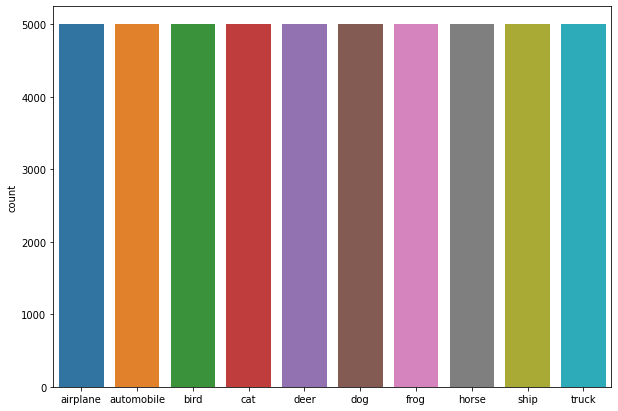

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

In [ ]:
# Check for NaN Values

np.isnan(x_train).any()

False

In [ ]:
# Check for NaN Values

np.isnan(x_test).any()

False

In [ ]:
# Normalization and Reshaping

input_shape = (32, 32, 3)

# x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

In [ ]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
y_train.shape, y_test.shape

((50000,), (10000,))

In [ ]:
# Label Encoding (클래스 벡터를 이진 클래스 매트릭스로 변환)

NUM_CLASSES = 10
# y_train = tf.one_hot(y_train.astype(np.int32), depth=NUM_CLASSES)
# y_test = tf.one_hot(y_test.astype(np.int32), depth=NUM_CLASSES)

y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


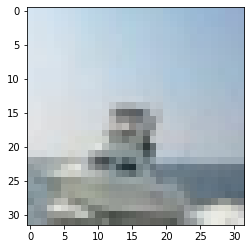

In [ ]:
# Visualize Data

plt.imshow(x_train[100])
print(y_train[100])

## CNN 기반의 심층 신경망 모델 구축
- ```케라스```로 convolution, 최대 풀링, 배치 정규화, 평탄화, 밀집층이 있는 간단한 CNN 모데을 만듬
- 드롭아웃으로 모델이 과대적합되지 않도록 함

In [ ]:
# Define the Model

batch_size = 32
num_classes = 10
epochs = 100  # 50

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                        

## 네트워크 아키텍처 시각화
- [SVG(Scalable Vector Graphics)](https://m.post.naver.com/viewer/postView.nhn?volumeNo=27689642&memberNo=43589165)
- [Tensorflow2.x model_to_dot()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/model_to_dot)
- [Keras plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)

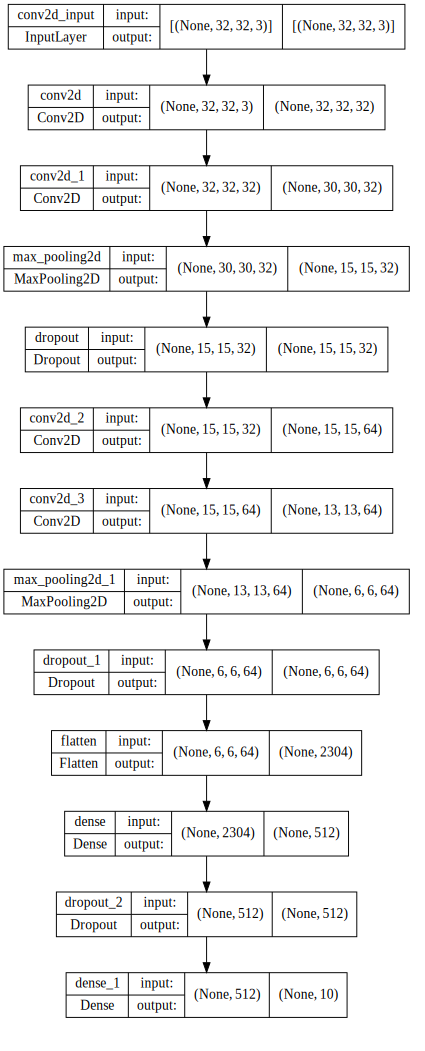

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, 
                 rankdir='TB', expand_nested=True, dpi=70).create(prog='dot', format='svg'))

## 모델 컴파일

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])



In [ ]:
!mkdir model
%ls

model/  sample_data/


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

KFOLD_WEIGHT_PATH=r'./model/cnn_cifar10_weights_{epoch:02d}_{val_acc:.2f}.hdf5'
early_stop_callback = [EarlyStopping(monitor='val_loss', 
                                     patience=3, verbose=0),
                       ModelCheckpoint(KFOLD_WEIGHT_PATH, 
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       verbose=0),
                      ]

## 분류기 훈련

In [ ]:
%%time
# colab : 약 5분 30초 소요됨, win : 약 분 소요됨

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=early_stop_callback)

Epoch 1/100
1407/1407 [==============================] - 24s 7ms/step - loss: 1.8447 - acc: 0.3250 - val_loss: 1.5523 - val_acc: 0.4394
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5189 - acc: 0.4470 - val_loss: 1.3803 - val_acc: 0.4990
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.3862 - acc: 0.5007 - val_loss: 1.3645 - val_acc: 0.5060
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.2894 - acc: 0.5385 - val_loss: 1.2135 - val_acc: 0.5688
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.2144 - acc: 0.5686 - val_loss: 1.1786 - val_acc: 0.5926
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.1477 - acc: 0.5928 - val_loss: 1.0531 - val_acc: 0.6340
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.0845 - acc: 0.6171 - val_loss: 1.0003 - val_acc: 0.6554
Epoch 8/100
1407/1407 [=========================

In [ ]:
model.save(filepath=r'./model/cnn_cifar10.h5')
%ls model

cnn_cifar10.h5                    cnn_cifar10_weights_10_0.69.hdf5
cnn_cifar10_weights_01_0.44.hdf5  cnn_cifar10_weights_12_0.71.hdf5
cnn_cifar10_weights_02_0.50.hdf5  cnn_cifar10_weights_14_0.73.hdf5
cnn_cifar10_weights_03_0.51.hdf5  cnn_cifar10_weights_16_0.73.hdf5
cnn_cifar10_weights_04_0.57.hdf5  cnn_cifar10_weights_17_0.74.hdf5
cnn_cifar10_weights_05_0.59.hdf5  cnn_cifar10_weights_18_0.75.hdf5
cnn_cifar10_weights_06_0.63.hdf5  cnn_cifar10_weights_19_0.75.hdf5
cnn_cifar10_weights_07_0.66.hdf5  cnn_cifar10_weights_21_0.76.hdf5
cnn_cifar10_weights_08_0.68.hdf5  cnn_cifar10_weights_24_0.76.hdf5
cnn_cifar10_weights_09_0.68.hdf5  cnn_cifar10_weights_25_0.78.hdf5


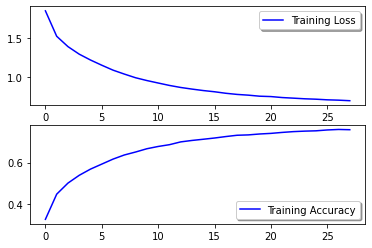

In [ ]:
# Loss and Accuracy Curves

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 모델 성능 예측과 테스트

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

test_loss, test_acc 

313/313 [==============================] - 1s 4ms/step - loss: 0.8129 - acc: 0.7356


(0.8128819465637207, 0.7355999946594238)

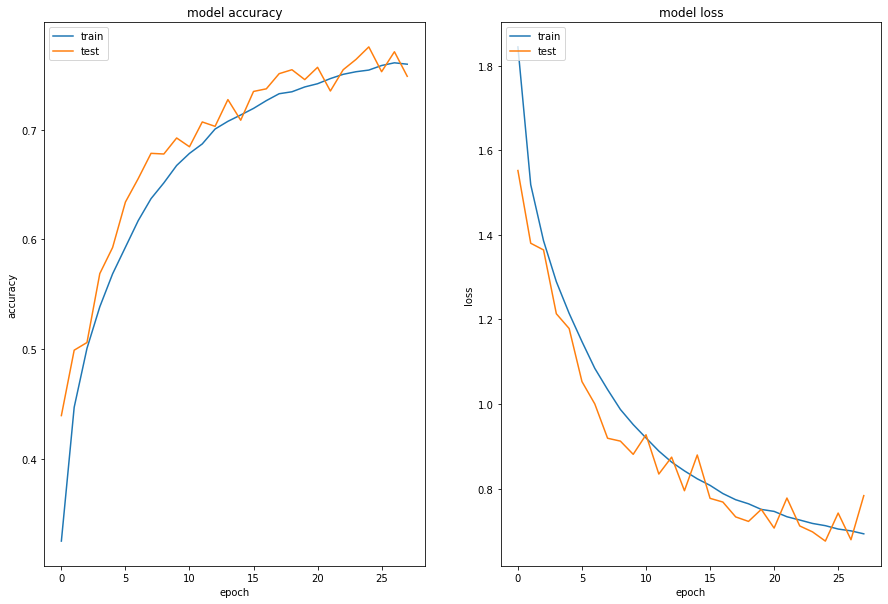

In [ ]:

plt.figure(1,figsize=(15,10))  

# summarize history for accuracy  

plt.subplot(121)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(122)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

[[Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')],
 [Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')]]

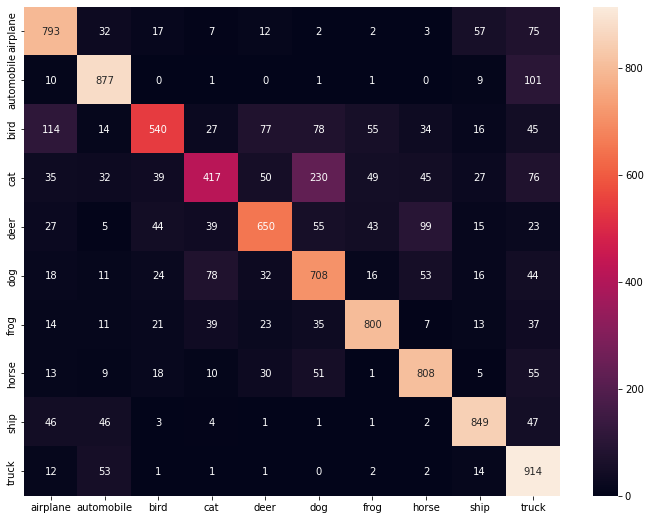

In [ ]:
# Confusion Matrix

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=classes, yticklabels=classes)